# Model Evaluation, Cross-Validation, and Hyperparameter Tuning 

This file explores the initial performance of several machine learning models and conducts additional tests to improve model predictions. 

In [265]:
import warnings # ignore those warnings!

# general use packages
import matplotlib.pyplot as plt # visualization
from datetime import date # ensure out date column is indeed a data column
import seaborn as sns # more viz
import numpy as np # basic munging
import pandas as pd # data management

# model packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



# model assessment
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

warnings.filterwarnings('ignore')

# %run Boston_311_Master_Merger_V2.ipynb

master = pd.read_csv("~/Documents/Georgetown SCS/capstone/boston-311/01 data/master.csv")

## Encoding

We're going to try two different encoding approaches:
1. One-hot encoding for our main string features of interest (source of 311 call and reason for 311 call) to widen our data frame and turn each string into its own 0/1 column
2. Ordinal encoding of string variables, which will keep our feature space the same, but ensure we are only dealing with numeric data

In [266]:
master.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492757 entries, 0 to 492756
Data columns (total 104 columns):
 #    Column                                              Dtype  
---   ------                                              -----  
 0    Unnamed: 0                                          int64  
 1    case_enquiry_id                                     int64  
 2    open_dt                                             object 
 3    target_dt                                           object 
 4    closed_dt                                           object 
 5    ontime                                              object 
 6    case_status                                         object 
 7    closure_reason                                      object 
 8    case_title                                          object 
 9    subject                                             object 
 10   reason                                              object 
 11   type                    

In [267]:
master.isna().sum()

Unnamed: 0             0
case_enquiry_id        0
open_dt                0
target_dt          72801
closed_dt          32715
                   ...  
Shape_STAr            51
Shape_STLe            51
ucr_one               51
ucr_two               51
total_ucr             51
Length: 104, dtype: int64

In [268]:
# let's split out our date columns

# first ensure our date column is indeed a date column
master['date'] = pd.to_datetime(master['date'])

# Breakout day, month, and year from the date field
master['day'] = master['date'].dt.day
master['month'] = master['date'].dt.month
master['year'] = master['date'].dt.year

# let's also ensure we only have numeric values

master['Total_P1'] = pd.to_numeric(master.Total_P1, errors='coerce')

master['GEOID20'] = pd.to_numeric(master.GEOID20, errors='coerce')


## Select the fields that will potentially be used for further feature selection and later modeling

In [269]:
# Define the fields we will use for ML
cols = ['case_enquiry_id','date','ontime','case_status','subject','reason'
        ,'PRCP'
        ,'Total_P1','GEOID20','ucr_one','ucr_two','total_ucr']
master = master[cols]

In [270]:
## Encoding

In [271]:
# One-hot encode categorical features
master_one_hot= pd.get_dummies(data=master, columns=['reason', 'subject', 'ontime'])

master_one_hot['closed'] = master_one_hot['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

master_one_hot = master_one_hot.drop('case_status', axis=1)

master_one_hot.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492757 entries, 0 to 492756
Data columns (total 75 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   case_enquiry_id                            492757 non-null  int64         
 1   date                                       492757 non-null  datetime64[ns]
 2   PRCP                                       492757 non-null  float64       
 3   Total_P1                                   492706 non-null  float64       
 4   GEOID20                                    492706 non-null  float64       
 5   ucr_one                                    492706 non-null  float64       
 6   ucr_two                                    492706 non-null  float64       
 7   total_ucr                                  492706 non-null  float64       
 8   reason_Abandoned Bicycle                   492757 non-null  uint8         
 9   reas

In [272]:
# create simple numeric columns

# there is definitely an easier way to do this, but it didn't work when I combined these into a function
master_numeric = master
master_numeric['reason'] = pd.factorize(master_numeric['reason'])[0]
master_numeric['subject'] = pd.factorize(master_numeric['subject'])[0]
master_numeric['ontime'] = pd.factorize(master_numeric['ontime'])[0]



In [273]:
master_numeric.shape

(492757, 12)

In [274]:
master_numeric = master_numeric.dropna(subset = ['GEOID20'])

master_numeric.shape

(492706, 12)

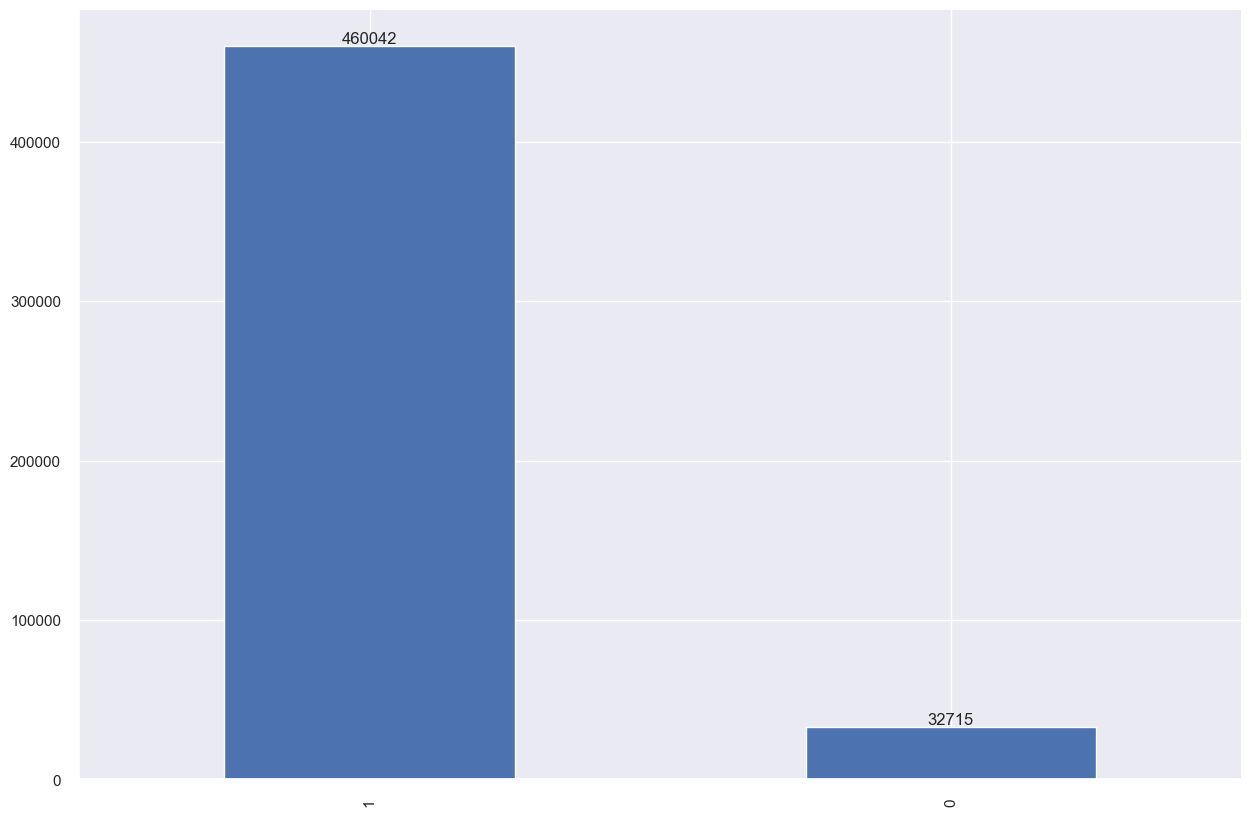

In [275]:
# we clearly have class imbalance
%matplotlib inline

sns.set_theme(style="darkgrid")

status_count_fig = master_one_hot['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [276]:
# let's rebalance with undersampling

closed=master_one_hot[master_one_hot.closed==1]
open=master_one_hot[master_one_hot.closed==0]

# upsample minority
open_upsampled = resample(open
                            , replace=True # sample with replacement 
                            , n_samples=len(closed) # match number in majority class
                          , random_state=12022022) # set seed

# combine majority and upsampled minority
upsampled = pd.concat([closed, open_upsampled])

# check new class counts
upsampled.closed.value_counts()

1    460042
0    460042
Name: closed, dtype: int64

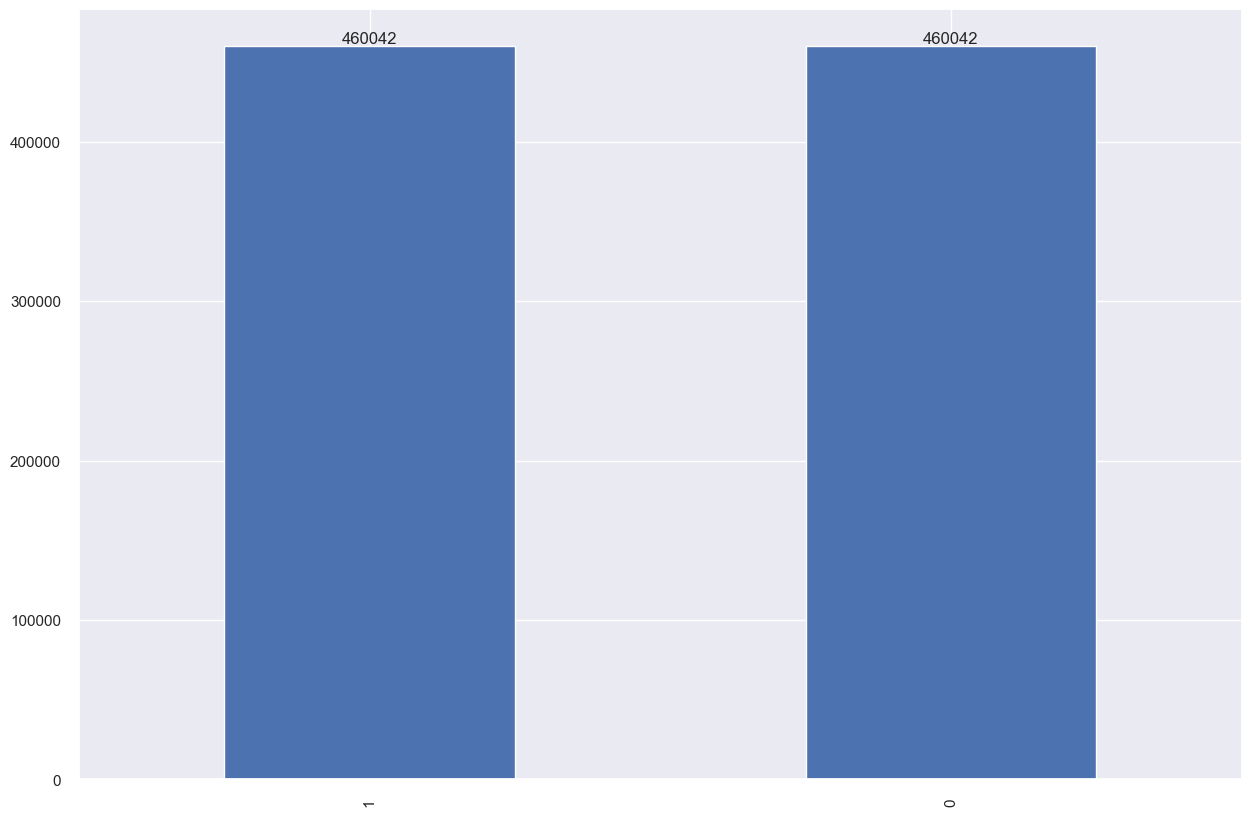

In [277]:
# now let's check our balance
status_count_fig = upsampled['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [278]:
# Prepare data for modeling

import datetime as dt
upsampled = upsampled.dropna(subset = ['GEOID20'])


X = upsampled.drop('closed', axis=1)
X = X.drop('case_enquiry_id', axis = 1)
X['date']=X['date'].map(dt.datetime.toordinal)

y = upsampled['closed']



#### test, train split


In [279]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
     

In [280]:
from xgboost import XGBRegressor
import xgboost as xgb

xgb_reg = XGBRegressor(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10) 
# fit model
xgb_reg.fit(X_train, y_train)
# make predictions
preds = xgb_reg.predict(X_test)


In [281]:
# check the performance
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE: %f" % (rmse))

# not bad


RMSE: 0.389463


In [282]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:48:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [283]:
# let's take a look
cv_results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.490588,0.000382,0.490589,0.000430
1,0.473996,0.011995,0.473998,0.012062
2,0.455544,0.019093,0.455548,0.019167
3,0.433920,0.016736,0.433937,0.016826
4,0.418065,0.022636,0.418090,0.022738


In [284]:
print((cv_results["test-rmse-mean"]).tail(1))
# cross validation reduced our RMSE

49    0.250228
Name: test-rmse-mean, dtype: float64


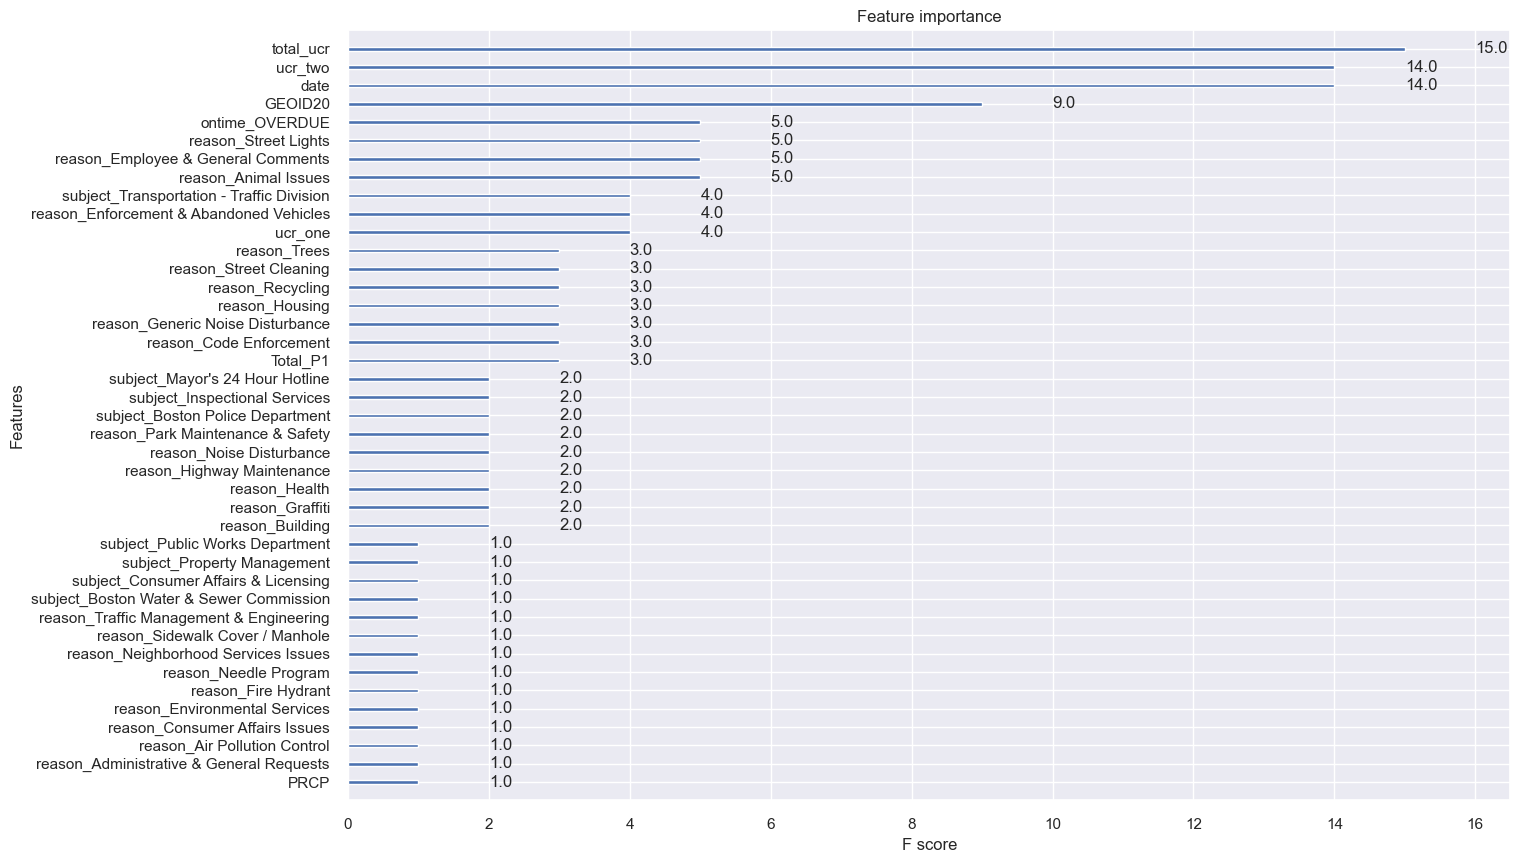

In [285]:
# let's look at feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [ ]:

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))



models = [
    LogisticRegression()
    #, ExtraTreesClassifier()
    , RandomForestClassifier()
]

for model in models:
    score_model(X, y, model)
    

In [ ]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['0', '1'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)


In [ ]:
df = X
df['closed'] = y

df['GEOID20'] = df['GEOID20'].apply(str)

def GroupRegress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    result = LogisticRegression().fit(X,Y)
    return result

df.groupby('GEOID20').apply(GroupRegress, 'closed', ['ucr_total'])

In [ ]:
closed_calls = df.groupby("GEOID20").agg({'closed': ['sum']}).reset_index()   
closed_calls.columns = ['GEOID20', 'sum']

closed_calls.sort_values('sum', ascending=True)

In [208]:
call_counts = df.groupby(['GEOID20'])['closed'].agg('sum').reset_index()   

In [219]:
call_counts2 = call_counts[call_counts["closed"] > 100]

In [229]:
df2 = df.loc[df['GEOID20'].isin(call_counts2['GEOID20'])]


In [231]:
df2.head()

,date,PRCP,Total_P1,GEOID20,ucr_one,ucr_two,total_ucr,reason_Abandoned Bicycle,reason_Administrative,reason_Administrative & General Requests,...,subject_Inspectional Services,subject_Mayor's 24 Hour Hotline,subject_Neighborhood Services,subject_Parks & Recreation Department,subject_Property Management,subject_Public Works Department,subject_Transportation - Traffic Division,ontime_ONTIME,ontime_OVERDUE,closed
0,735764,0.4,2120.0,250251101051.0,101.0,436.0,537.0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,735764,0.4,610.0,250250701042.0,617.0,1644.0,2261.0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,735764,0.4,719.0,250251204002.0,53.0,58.0,111.0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
6,735764,0.4,2282.0,250250008071.0,31.0,182.0,213.0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
7,735764,0.4,1025.0,250250304002.0,55.0,124.0,179.0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [286]:
def GroupRegress(data, yvar, xvars):
    y = data[yvar]
    X = data[xvars]
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    result = RandomForestClassifier().fit(X,y)
    preds = result.predict(X_test)
    return preds

outcomes = df2.groupby('GEOID20').apply(GroupRegress, 'closed', ['total_ucr', 'ucr_one', 'ucr_two'
                                                                         ,'reason_Abandoned Bicycle',
                                                                        'reason_Administrative',
                                                                        'reason_Administrative & General Requests',
                                                                        'reason_Air Pollution Control',
                                                                        'reason_Alert Boston',
                                                                        'reason_Animal Issues',
                                                                        'reason_Billing',
                                                                        'reason_Boston Bikes',
                                                                        'reason_Bridge Maintenance',
                                                                        'reason_Building',
                                                                        'reason_Catchbasin',
                                                                        'reason_Cemetery',
                                                                        'reason_Code Enforcement',
                                                                        'reason_Consumer Affairs Issues',
                                                                        'reason_Current Events',
                                                                        'reason_Disability',
                                                                        'reason_Employee & General Comments',
                                                                        'reason_Enforcement & Abandoned Vehicles',
                                                                        'reason_Environmental Services',
                                                                        'reason_Fire Department',
                                                                        'reason_Fire Hydrant',
                                                                        'reason_General Request',
                                                                        'reason_Generic Noise Disturbance',
                                                                        'reason_Graffiti',
                                                                        'reason_Health',
                                                                        'reason_Highway Maintenance',
                                                                        'reason_Housing',
                                                                        'reason_MBTA',
                                                                        'reason_Massport',
                                                                        'reason_Needle Program',
                                                                        'reason_Neighborhood Services Issues',
                                                                        'reason_Noise Disturbance',
                                                                        'reason_Notification',
                                                                        'reason_Office of The Parking Clerk',
                                                                        'reason_Operations',
                                                                        'reason_Park Maintenance & Safety',
                                                                        'reason_Parking Complaints',
                                                                        'reason_Pothole',
                                                                        'reason_Programs',
                                                                        'reason_Recycling',
                                                                        'reason_Sanitation',
                                                                        'reason_Sidewalk Cover / Manhole',
                                                                        'reason_Signs & Signals',
                                                                        'reason_Street Cleaning',
                                                                        'reason_Street Lights',
                                                                        'reason_Test Cases',
                                                                        'reason_Traffic Management & Engineering',
                                                                        'reason_Trees',
                                                                        'reason_Valet',
                                                                        'reason_Water Issues',
                                                                        'reason_Weights and Measures',
                                                                        'subject_Animal Control',
                                                                        'subject_Boston Police Department',
                                                                        'subject_Boston Water & Sewer Commission',
                                                                        'subject_CRM Application',
                                                                        'subject_Consumer Affairs & Licensing',
                                                                        'subject_Disability Department',
                                                                        'subject_Inspectional Services',
                                                                        "subject_Mayor's 24 Hour Hotline",
                                                                        'subject_Neighborhood Services',
                                                                        'subject_Parks & Recreation Department',
                                                                        'subject_Property Management',
                                                                        'subject_Public Works Department',
                                                                        'subject_Transportation - Traffic Division',
                                                                        'ontime_ONTIME',
                                                                        'ontime_OVERDUE'])

In [288]:
X_test['predictions'] = preds


In [290]:
output_df = X_test.groupby(['GEOID20'])['predictions'].mean().reset_index()


In [291]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEOID20      578 non-null    float64
 1   predictions  578 non-null    float32
dtypes: float32(1), float64(1)
memory usage: 6.9 KB


In [295]:
output_df.to_csv("~/Documents/Georgetown SCS/capstone/boston-311/03 output/predictions.csv")